# L-RVGA comparisson

In this notebook, we make use of the [XP_LRVGA_LinearRegression.py](https://github.com/marc-h-lambert/L-RVGA/blob/main/XP_LRVGA_LinearRegression.py) script to benchmark L-RVGA and LoFi.

In [1]:
import jax
import pickle
import distrax
import numpy as np
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from typing import Callable
from rebayes.base import RebayesParams
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi
from rebayes.low_rank_filter import lrvga

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [3]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

## Load data

In [4]:
file = "./LRVGA_data.pkl"
with open(file, "rb") as f:
    data = pickle.load(f)

# To TPU
data = jax.tree_map(jnp.array, data)
jax.tree_map(jnp.shape, data)

{'X': (10000, 100),
 'cov_inputs': (100, 100),
 'ekf-divergence': {'full-kf': (9999, 1),
  'p-1': (9999, 1),
  'p-10': (9999, 1),
  'p-100': (9999, 1),
  'p-20': (9999, 1),
  'p-50': (9999, 1)},
 'kf-posterior-cov': (100, 100),
 'kf-posterior-mean': (100, 1),
 'params_true': (100,),
 'y': (10000,)}

### Compute posterior parameters

In [5]:
# Explicit solution
_, num_features = data["X"].shape
pcov = jnp.linalg.inv(data["X"].T @ data["X"] + jnp.eye(num_features))
pmean = pcov @ data["X"].T @ data["y"]

In [6]:
# From KF result
pcov = data["kf-posterior-cov"]
pmean = data["kf-posterior-mean"].ravel()

## Initialise Rebayes

In [7]:
def callback(bel, pred_obs, *args, **kwargs):
    dist_true = tfd.MultivariateNormalFullCovariance(pmean, pcov)
    dist_ekf = tfd.MultivariateNormalFullCovariance(bel.mean, bel.cov)
    
    kld = tfd.kl_divergence(dist_ekf, dist_true)
    return {
        "kl": kld
    }

In [8]:
num_samples, num_features = data["X"].shape

In [9]:
initial_mean = jnp.zeros(num_features)
dynamics_covariance = 1.0
initial_covariance = 1.0
dynamics_weights = 1.0

def emission_cov_fn(w, x): return 1.0
def emission_mean_fn(w, x): return jnp.einsum("m,...m->", w, x)

In [10]:
params = RebayesParams(
    initial_mean,
    initial_covariance,
    dynamics_weights,
    dynamics_covariance,
    emission_mean_fn,
    emission_cov_fn
)


# Try 50, 99, and 100. See differences
params_lofi50 = lofi.LoFiParams(memory_size=50, adaptive_variance=False)
params_lofi99 = lofi.LoFiParams(memory_size=99, adaptive_variance=False)
params_lofi100 = lofi.LoFiParams(memory_size=100, adaptive_variance=False)

In [11]:
estimator_kf = ekf.RebayesEKF(params, method="fcekf", adaptive_variance=False)
estimator_lofi50 = lofi.RebayesLoFi(params, params_lofi50, "full_svd_lofi")
estimator_lofi99 = lofi.RebayesLoFi(params, params_lofi99, "full_svd_lofi")
estimator_lofi100 = lofi.RebayesLoFi(params, params_lofi100, "full_svd_lofi")

In [12]:
output_lofi50, hist_lofi50 = estimator_lofi50.scan(data["X"], data["y"], callback=callback)
output_lofi99, hist_lofi99 = estimator_lofi99.scan(data["X"], data["y"], callback=callback)
output_lofi100, hist_lofi100 = estimator_lofi100.scan(data["X"], data["y"], callback=callback)
output_kf, hist_kf = estimator_kf.scan(data["X"], data["y"], callback=callback)

output_kf = jax.block_until_ready(output_kf)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

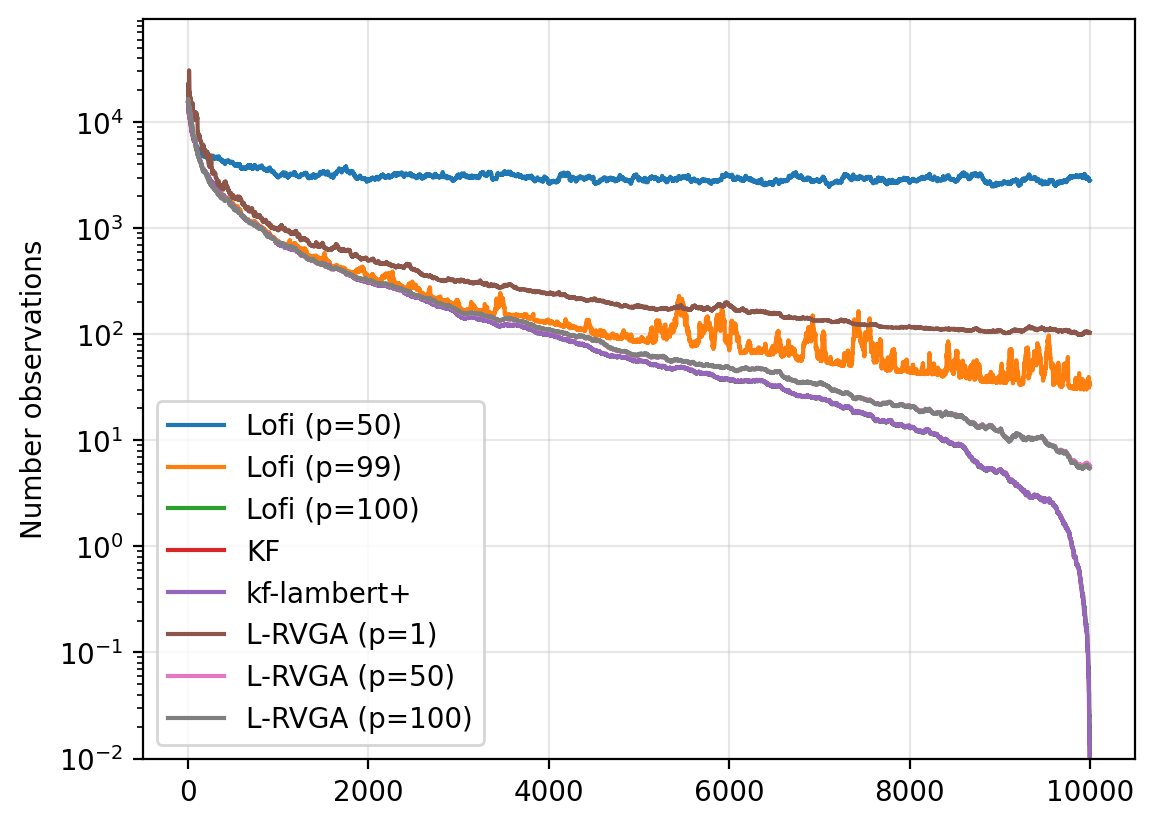

In [13]:
plt.plot(hist_lofi50["kl"], label="Lofi (p=50)")
plt.plot(hist_lofi99["kl"], label="Lofi (p=99)")
plt.plot(hist_lofi100["kl"], label="Lofi (p=100)")

plt.plot(hist_kf["kl"], label="KF")
plt.plot(data["ekf-divergence"]["full-kf"].ravel(), label="kf-lambert+")

plt.plot(data["ekf-divergence"]["p-1"].ravel(), label="L-RVGA (p=1)")
plt.plot(data["ekf-divergence"]["p-50"].ravel(), label="L-RVGA (p=50)")
plt.plot(data["ekf-divergence"]["p-100"].ravel(), label="L-RVGA (p=100)")
plt.legend()
plt.ylabel("KL(q||p)")
plt.yscale("log")
ymin, ymax = plt.ylim()
plt.ylim(10 ** -2, ymax)
plt.ylabel("Number observations")
plt.grid(alpha=0.3)

In [14]:
dist_true = tfd.MultivariateNormalFullCovariance(pmean, pcov)
dist_ekf = tfd.MultivariateNormalFullCovariance(output_kf.mean, output_kf.cov)

tfd.kl_divergence(dist_ekf, dist_true)

Array(7.632261e-06, dtype=float32)

In [15]:
dist_lofi = tfd.MultivariateNormalFullCovariance(output_lofi100.mean, output_lofi100.cov)
tfd.kl_divergence(dist_lofi, dist_true)

Array(0.01077911, dtype=float32)

In [16]:
dist_lofi = tfd.MultivariateNormalFullCovariance(output_lofi100.mean, output_lofi100.cov)
tfd.kl_divergence(dist_lofi, dist_true)

Array(0.01077911, dtype=float32)

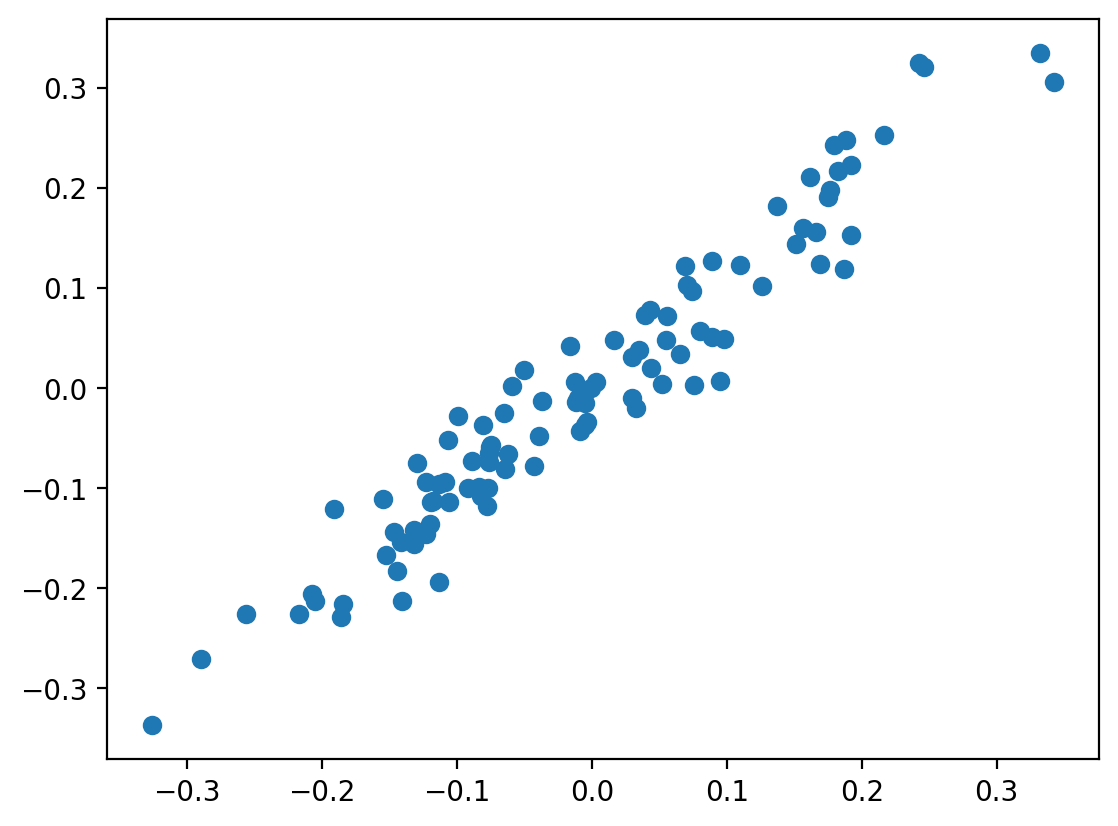

In [17]:
plt.scatter(output_kf.mean, output_lofi99.mean)

## L-RVGA (Rebayes / Lambert)

In [18]:
dim_ranks = {
    10: "tab:red",
    20: "tab:blue",
    50: "tab:green",
    100: "tab:orange",
}

In [19]:
class LReg(nn.Module):
    activation: Callable = nn.elu
    
    def setup(self):
        self.mean = nn.Dense(1, use_bias=False)
    
    @nn.compact
    def __call__(self, x):
        """
        Link_fn: h(θ, x) = θ^T x
        """
        mean = self.mean(x)
        return mean

In [20]:
hparams = {
    "sigma2": 1.0,
    "eps": 1e-3 # 1e-8 gets rounded to 1.0
}

key = jax.random.PRNGKey(3141)
dim_rank = 50
std = 1.0
model = LReg()
bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, data["X"], dim_rank, std, **hparams)
bel_init = bel_init.replace(mu=bel_init.mu * 0.0)

In [21]:
def fwd_link(mean, bel, x):
    params = reconstruct_fn(mean)
    means = model.apply(params, x).ravel()
    std = bel.sigma
    return means, std ** 2

def log_prob(mean, bel, x, y):
    yhat, std = fwd_link(mean, bel, x)
    std = jnp.sqrt(std)
    
    logp = distrax.Normal(yhat, std).log_prob(y).sum()
    return logp

In [22]:
estimator_lrvga = lrvga.LRVGA(fwd_link, log_prob, n_samples=30, n_outer=1, n_inner=3)

In [23]:
collection_hist_lrvga = {}
for dim_rank in dim_ranks:    
    bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, data["X"], dim_rank, std, **hparams)
    bel_init = bel_init.replace(mu=bel_init.mu * 0.0)
    output_lrvga, hist_lrvga = estimator_lrvga.scan(data["X"], data["y"], callback=callback, bel=bel_init)
    collection_hist_lrvga[dim_rank] = hist_lrvga["kl"]

collection_hist_lrvga = jax.tree_map(np.array, collection_hist_lrvga)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

dim_rank=10
KL-Lambert 23.475
KL-Rebayes 20.066

dim_rank=20
KL-Lambert 14.574
KL-Rebayes 13.511

dim_rank=50
KL-Lambert 5.744
KL-Rebayes 5.618

dim_rank=100
KL-Lambert 5.438
KL-Rebayes 5.540



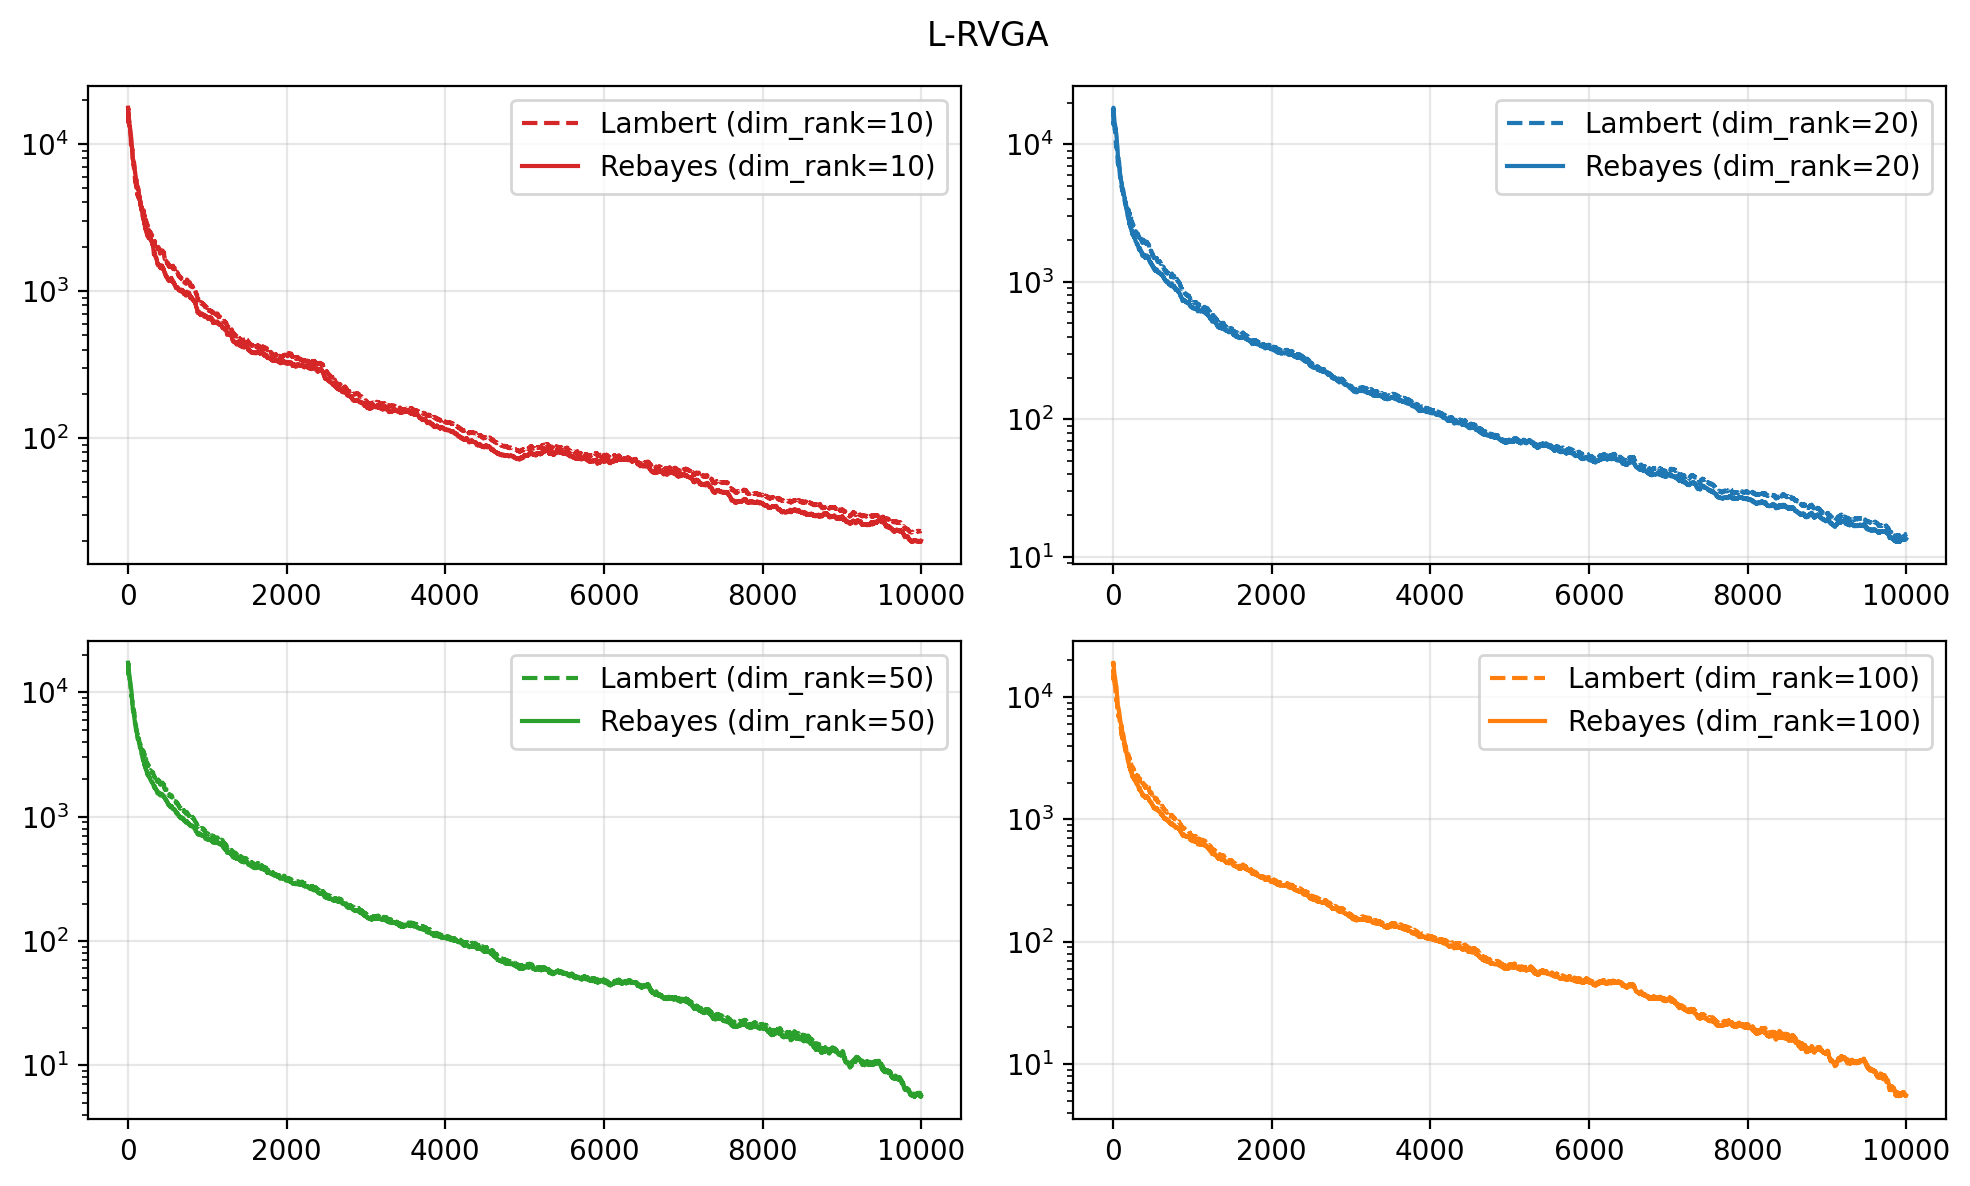

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.ravel()
for ax, dim_rank in zip(axs, dim_ranks):
    color = dim_ranks[dim_rank]
    kl_lambert = data["ekf-divergence"][f"p-{dim_rank}"].ravel()
    kl_rebayes = collection_hist_lrvga[dim_rank]
    ax.plot(kl_lambert, label=f"Lambert ({dim_rank=})", color=color, linestyle="--")
    ax.plot(kl_rebayes, label=f"Rebayes ({dim_rank=})", color=color)
    ax.legend()
    ax.set_yscale("log")
    ax.grid(alpha=0.3)
    
    kl_lambert_last = kl_lambert[-1].item()
    kl_rebayes_last = kl_rebayes[-1].item()
    print(f"{dim_rank=}")
    print(f"KL-Lambert {kl_lambert_last:0.3f}")
    print(f"KL-Rebayes {kl_rebayes_last:0.3f}", end="\n" * 2)
plt.suptitle("L-RVGA")
plt.tight_layout()

### Increasingo number of samples for L-RVGA

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 42 s, sys: 1.37 s, total: 43.3 s
Wall time: 1min 43s


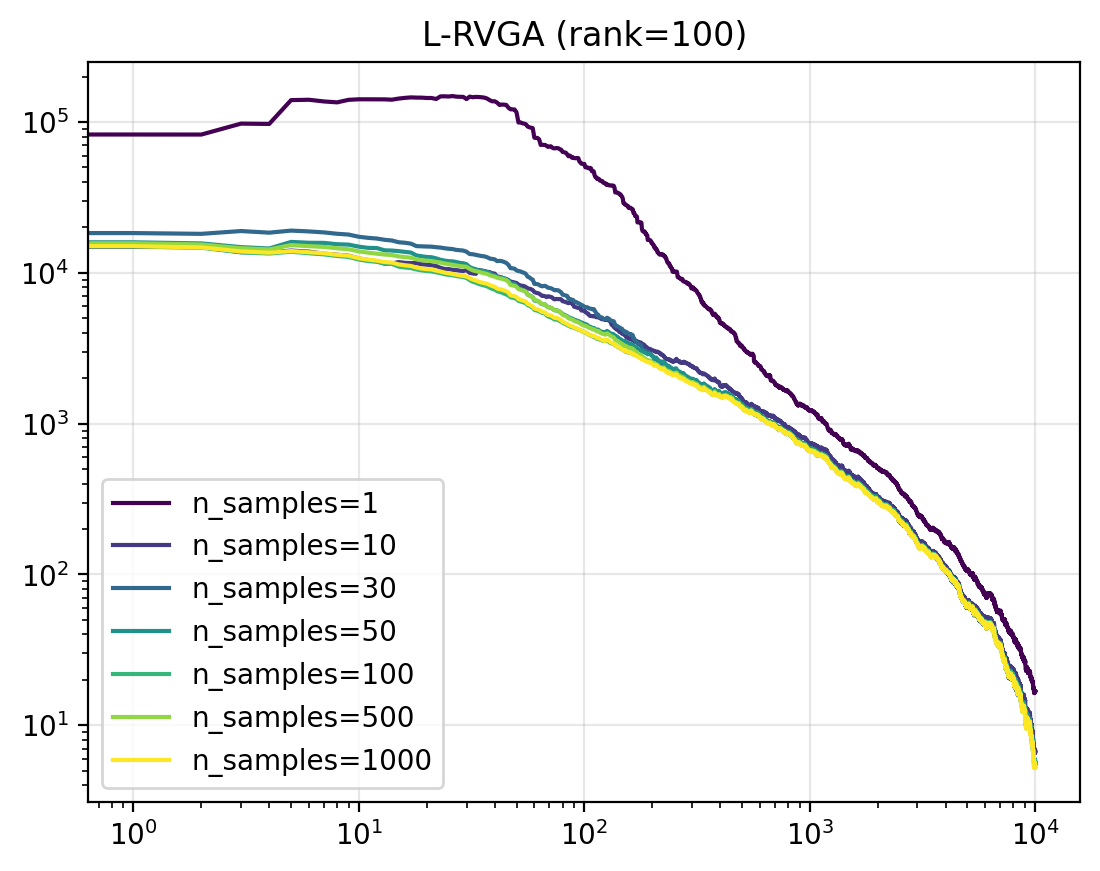

In [26]:
%%time
dim_rank = 100
n_samples_list = [1, 10, 30, 50, 100, 500, 1000]
colors = plt.cm.viridis(np.linspace(0, 1, len(n_samples_list)))

for c, n_samples in zip(colors, n_samples_list):
    estimator_lrvga = lrvga.LRVGA(fwd_link, log_prob, n_samples=n_samples, n_outer=1, n_inner=3)
    bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, data["X"], dim_rank, std, **hparams)
    bel_init = bel_init.replace(mu=bel_init.mu * 0.0)
    output_lrvga, hist_lrvga = estimator_lrvga.scan(data["X"], data["y"], callback=callback, bel=bel_init)
    plt.plot(hist_lrvga["kl"], label=f"{n_samples=}", c=c)
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.title("L-RVGA (rank=100)")
plt.grid(alpha=0.3)